# X-Risk Exploratory Data Analysis

In this notebook we go through the existential risk database to learn about the estimates made by different people on the subject.

**Note from a human 🤓**: For this work, I used Claude AI to help me formulate some text sections and to help me process some data. I wrote most of it, and whatever I used from Claude I have thoroughly read. There are some sections entirely written by Claude AI though, which I've marked with 🤖. In those sections you'll find a "Note from a human 🤓" with an explanation.

In [350]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_theme(style='darkgrid')
orig_size = plt.rcParams['figure.figsize']

In [351]:
# Load the data
df = pd.read_csv('./data/processed_estimates/all_estimates.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83 entries, 0 to 82
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   estimator                      83 non-null     object 
 1   original_estimate              83 non-null     object 
 2   per_century_risk               83 non-null     float64
 3   estimate_confidence            83 non-null     object 
 4   conversion_confidence          83 non-null     object 
 5   reasoning                      83 non-null     object 
 6   risk_category                  83 non-null     object 
 7   estimate_confidence_numeric    83 non-null     int64  
 8   conversion_confidence_numeric  83 non-null     int64  
 9   date                           83 non-null     int64  
dtypes: float64(1), int64(3), object(6)
memory usage: 6.6+ KB


In [352]:
# Get the unique risk categories
xrisk_categories = set(df['risk_category'])
print(f'There are {len(xrisk_categories)} unique risk categories:\n-\t{"\n-\t".join(xrisk_categories)}')

There are 10 unique risk categories:
-	dystopia
-	nuclear
-	biorisk
-	natural_risks
-	miscellaneous
-	ai
-	war
-	climate_change
-	total
-	nanotechnology


# Initial Observations

With only 81 estimates spread across approximately 9-10 risk categories, we're working with an average of just 8-9 estimates per category. This limited data presents several important statistical challenges and implications.

The small sample size affects the reliability and robustness of our statistical analyses in multiple ways. 

First, with such limited data points per category, individual estimates carry disproportionate weight and outliers can significantly skew results. 

Second, traditional statistical tests and correlation analyses become less reliable with small sample sizes, as they typically require larger datasets to detect meaningful patterns with confidence.


In [353]:
categories_aliases = {
    "ai": "AI",
    "natural_risks": "Natural\nRisks",
    "nanotechnology": "Nanotech",
    "climate_change": "Climate\nChange",
    "war": "War",
    "miscellaneous": "Misc",
    "biorisk": "Biorisk",
    "total": "Total\nRisk",
    "dystopia": "Dystopia",
    "nuclear": "Nuclear",
}
df['category_alias'] = df['risk_category'].map(categories_aliases)


Text(0.5, 0, 'Risk category')

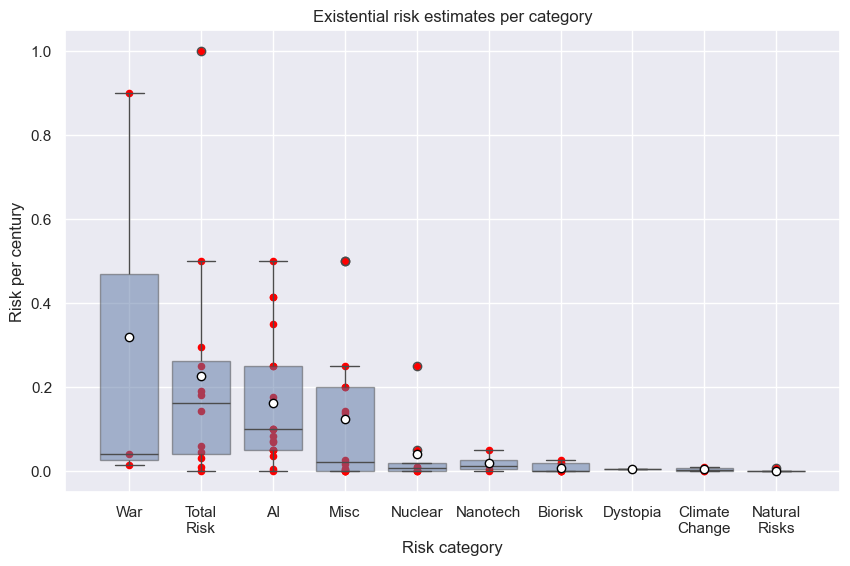

In [354]:
# Plot the risk categories as scatter plot.
ordered_categories_by_mean_risk = df.groupby('category_alias')['per_century_risk'].mean().sort_values(ascending=False).index

ax = sns.boxplot(x='category_alias', y='per_century_risk', data=df, showmeans=True, meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black"}, boxprops=dict(alpha=0.5), order=ordered_categories_by_mean_risk)

df.plot(kind='scatter', x='category_alias', y='per_century_risk', color='red', figsize=(10, 6), ax=ax)

ax.set_title('Existential risk estimates per category')
ax.set_ylabel('Risk per century')
ax.set_xlabel('Risk category')


In [355]:
df.groupby('risk_category')['per_century_risk'].agg(['mean', 'median', 'std']).sort_values(by='median', ascending=False)

,mean,median,std
risk_category,,,
total,0.225332,0.161500,0.283787
ai,0.161579,0.100000,0.154940
war,0.318000,0.040000,0.504194
miscellaneous,0.124088,0.020850,0.170602
nanotechnology,0.017950,0.010850,0.022473
nuclear,0.040523,0.006500,0.086250
dystopia,0.005000,0.005000,NaN
climate_change,0.004233,0.003165,0.004815
biorisk,0.008032,0.000500,0.010398


### Observations - TLDR

- War shows the highest median risk (~30%) with extremely wide uncertainty
- Total risk and AI follow as second and third highest risks (~20% and ~15% median)
- Natural risks show the lowest estimates (<1%) with high confidence
- Nuclear, nanotech, and biorisk cluster in the low-but-significant range (1-5%)
- Most categories show significant spread in estimates, indicating expert disagreement
- Climate change estimates are notably low.

We'll avoid a more detailed analysis for now, and save it for the end of the EDA.

# Time Based Analysis

Since we have data regarding when the observations were made, we could investigate if there is any correlation between the date when the estimate was made and the magnitude of the estimate. This would highlight a trend (if any), of whether experts are growing more or less concerned about existential risks as time passes.

Let's first view the magnitude of the analysis through time, as well as the count.

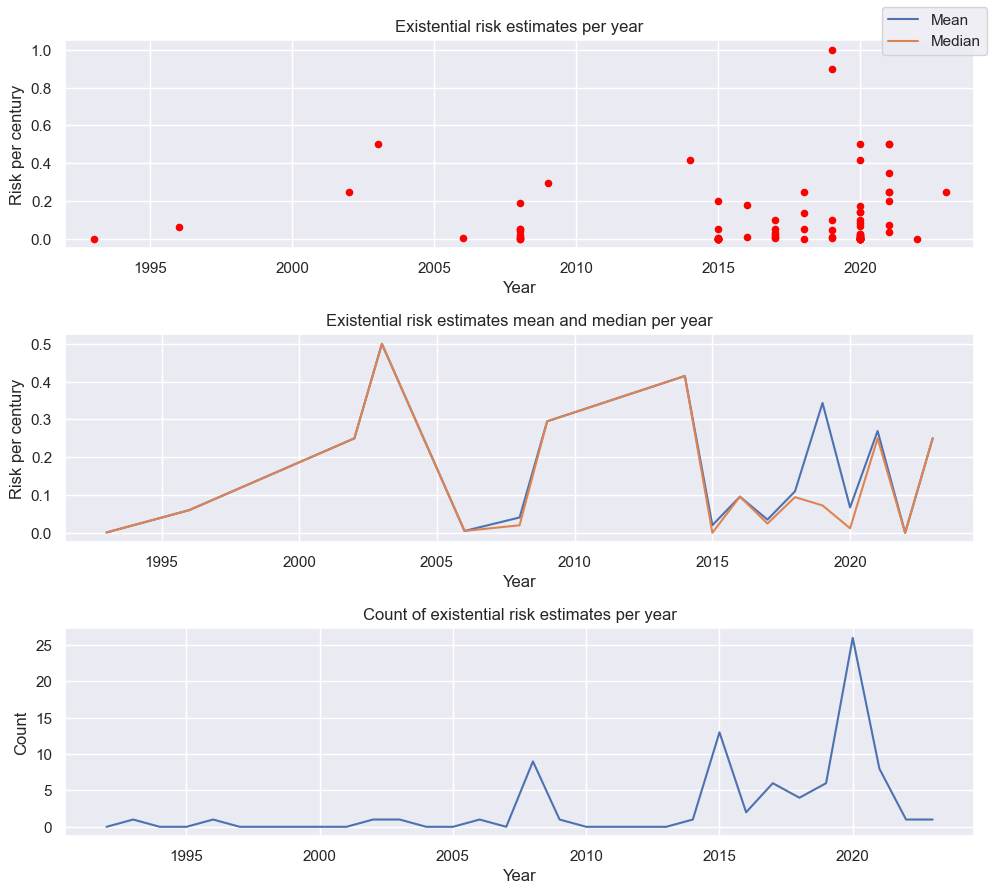

In [356]:
# Visualize the risk estimates through the years.
fig, axes = plt.subplots(3, figsize=(10, 9))
year_range = (df['date'].min()-1, df['date'].max()+1)

ax = axes[0]
df.plot(kind='scatter', x='date', y='per_century_risk', color='red', ax=ax)
ax.set_title('Existential risk estimates per year')
ax.set_ylabel('Risk per century')
ax.set_xlabel('Year')
ax.set_xlim(year_range)

ax = axes[1]
df.groupby('date')['per_century_risk'].mean().plot(ax=ax, label='Mean')
df.groupby('date')['per_century_risk'].median().plot(ax=ax, label='Median')
ax.set_title('Existential risk estimates mean and median per year')
ax.set_ylabel('Risk per century')
ax.set_xlabel('Year')
fig.legend()

# Visualize count of estimates per year
ax = axes[2]
value_count_per_year = np.zeros(year_range[1] - year_range[0])
for year in range(*year_range):
  value_count_per_year[year - year_range[0]] = df[df['date'] == year].shape[0]
ax.plot(range(*year_range), value_count_per_year)
ax.set_title('Count of existential risk estimates per year')
ax.set_ylabel('Count')
ax.set_xlabel('Year')
fig.tight_layout()

Based on these visualizations of existential risk estimates across all categories from 1995 to 2020, we can draw several important conclusions. The top scatter plot shows individual estimates becoming more frequent and more varied in recent years, with estimates ranging from near 0% to about 50% risk per century. The middle plot, showing mean and median trends, reveals notable volatility in expert estimates over time, with several significant spikes around 2005 and 2015 where estimates reached approximately 50% risk, though generally hovering between 10-30% in more recent years.

Perhaps most tellingly, the bottom plot demonstrates a dramatic increase in the number of existential risk estimates being made starting around 2015, with a particularly sharp peak in 2020. This surge in risk assessment activity suggests growing academic and professional interest in existential risks, possibly driven by rapid technological advancement and increasing awareness of global challenges. The higher frequency of estimates in recent years also provides a more robust dataset for analysis, though the wide spread of estimates indicates significant uncertainty and disagreement among experts about the magnitude of existential risks.

## Historical Context

Looking at the key time periods in the data, we can connect several significant historical events that likely influenced existential risk estimates:

*Early 2000s peak*: This period saw the aftermath of Y2K concerns, the 9/11 terrorist attacks, and growing awareness of climate change. The publication of influential works like Martin Rees' "Our Final Century" (2003) brought existential risks into broader academic discussion. These events highlighted humanity's vulnerability to both technological and human-made catastrophes.

*2015 surge*: This coincided with several watershed moments in technology and global risk awareness. The open letter warning about AI risks was published, signed by prominent figures like Stephen Hawking and Elon Musk. The Paris Climate Agreement highlighted growing concern about climate change. Additionally, the Global Challenges Foundation published their report on global catastrophic risks, which provided structured analysis of various existential threats.

*2020 peak*: The COVID-19 pandemic demonstrated how a global catastrophe could rapidly emerge and affect the entire world. This real-world example of a systemic risk likely prompted increased attention to existential risk assessment. This period also saw rapid advances in AI technology, particularly with GPT-3's release, which sparked new discussions about AI safety. The publication of Toby Ord's "The Precipice" provided a comprehensive framework for thinking about existential risks, likely inspiring many new estimates.

These historical contexts help explain why we see increased activity in risk assessment during these periods - each represented moments when global threats became more tangible to researchers and the public alike. 

## Correlation Analysis

We'll perform a correlation analysis to see if there is any significant correlation between the year an estimate was made and its magnitude.


Summary Statistics:
Mean estimate: 0.111
Median estimate: 0.020
Std dev: 0.190
Number of estimates: 83
Year range: 1993 - 2023

Correlation Analysis:
Pearson correlation coefficient: 0.085 (p-value: 0.444)
Spearman correlation coefficient: 0.154 (p-value: 0.166)


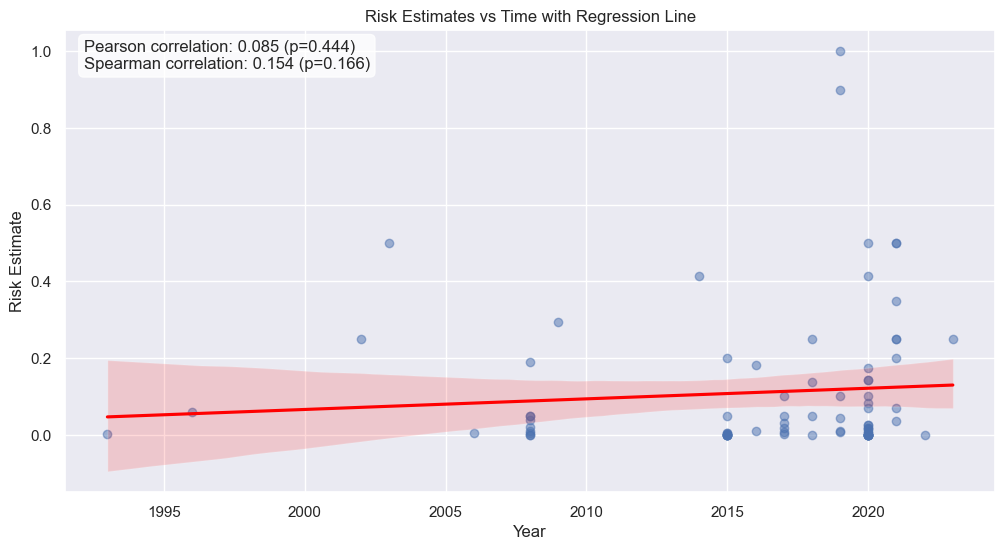

In [357]:
from scipy import stats

# Calculate correlation coefficients
pearson_corr, pearson_p = stats.pearsonr(df['date'], df['per_century_risk'])
spearman_corr, spearman_p = stats.spearmanr(df['date'], df['per_century_risk'])

# Create visualization
plt.figure(figsize=(12, 6))

# Scatter plot with regression line
sns.regplot(data=df, x='date', y='per_century_risk', scatter_kws={
            'alpha': 0.5}, line_kws={'color': 'red'})
plt.title('Risk Estimates vs Time with Regression Line')
plt.xlabel('Year')
plt.ylabel('Risk Estimate')

# Add correlation information
plt.text(0.02, 0.98,
         f'Pearson correlation: {pearson_corr:.3f} (p={pearson_p:.3f})\n' +
         f'Spearman correlation: {spearman_corr:.3f} (p={spearman_p:.3f})',
         transform=plt.gca().transAxes,
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Calculate summary statistics
summary_stats = {
    'Mean estimate': df['per_century_risk'].mean(),
    'Median estimate': df['per_century_risk'].median(),
    'Std dev': df['per_century_risk'].std(),
    'Number of estimates': len(df),
    'Year range': f"{df['date'].min()} - {df['date'].max()}"
}

print("\nSummary Statistics:")
for key, value in summary_stats.items():
    print(f"{key}: {value:.3f}" if isinstance(
        value, float) else f"{key}: {value}")

print("\nCorrelation Analysis:")
print(f"Pearson correlation coefficient: {pearson_corr:.3f} (p-value: {pearson_p:.3f})")
print(f"Spearman correlation coefficient: {spearman_corr:.3f} (p-value: {spearman_p:.3f})")

The Pearson correlation coefficient of 0.085 (p=0.444) and Spearman correlation of 0.154 (p=0.166) demonstrate there is essentially no significant relationship between when an estimate was made and its magnitude.

This finding remains important for this exploratory data analysis in several ways:

First, it confirms that temporal trends are not a meaningful factor in explaining the variation in existential risk estimates. Even though we saw spikes in estimate counts during certain periods (like 2015 and 2020), the actual risk magnitudes estimated during these periods weren't systematically different from other times, as evidenced by the high p-values (0.444 and 0.166) that indicate statistical insignificance.

Second, this allows us to treat estimates from different time periods as comparable, focusing instead on other factors that might explain variations in the estimates - such as the type of risk being assessed, the methodology used, or the background of the estimator.

Third, the wide spread of estimates across all time periods (as shown by the broad confidence interval in pink) suggests that disagreement among experts about existential risks has been a persistent feature of the field, rather than something that has either increased or decreased over time. This is particularly evident in the plot where we see estimates ranging from near 0 to as high as 1.0 in recent years.

This finding helps direct the rest of this analysis toward more promising avenues of investigation, such as comparing estimates across different risk categories or examining how different assessment methodologies might lead to different conclusions.

Furthermore, while we see increased estimation activity in recent years, many time periods have very few or no estimates for certain risk categories. This uneven temporal distribution makes it particularly challenging to draw reliable conclusions about trends or changes over time. The sparsity of data in earlier years also means we might be missing important historical perspectives or variations in risk assessment.

This limitation suggests we should be appropriately cautious in our interpretations and conclusions. While the dataset provides valuable insights into expert thinking about existential risks, any patterns or trends we observe should be considered preliminary rather than definitive. This observation also highlights the need for more systematic collection of existential risk estimates across all categories to build a more robust foundation for future analyses.


## Outliers

There are a few outliers in the data which we'll look at more in detail, to see if they were perhaps conversion errors by Claude or something else.



### Nuclear

There's a value of 25% for nuclear risk which seems suspect, given that all other values are so low.


In [358]:
# Get outlier from nanotech category and risk above 20%
nuclear_outlier = df[(df['risk_category'] == 'nuclear') & (df['per_century_risk'] > 0.2)]
nuclear_outlier

,estimator,original_estimate,per_century_risk,estimate_confidence,conversion_confidence,reasoning,risk_category,estimate_confidence_numeric,conversion_confidence_numeric,date,category_alias
37,Dave Denkenberger,0.29% annual,0.25,medium,medium,Converted annual to century using compound pro...,nuclear,2,2,2018,Nuclear


In [359]:
# Print the value and reasoning
print(f'Reasoning: {nuclear_outlier["reasoning"].values[0]}')

Reasoning: Converted annual to century using compound probability: 1-(1-0.0029)^100.


Okay, so Claude tried to convert the value from 0.29% annual to a per century risk using compound probability, which he did correctly.

Let's confirm this:

I introduce the following variables and probabilities:

$$
\begin{align}
E&: \text{Existential catastrophe occurs} \\
P_1(E)&: \text{Existential risk per year}=0.0029 \\
P_{100}(E)&: \text{Existential risk per century}=?
\end{align}
$$

If the annual risk estimate is 0.29%, then we ask, how likely is it that this risk doesn't happen for 100 years in a row?

We can express that as: $(1-P_1(E))^{100}$, and the complement probability is that the risk will occur at least once in 100 years, so we get

$$
\begin{align}
P(R_1) &= 0.0029 \\
P(R_{100}) &= 1-P'(R_1)^{100} \\
P(R_{100}) &= 1-(1-P(R_1))^{100} \\
P(R_{100}) &= 1-(1-0.0029)^{100} \\
P(R_{100}) &\approx 0.252 \text{ or } 25\%
\end{align}
$$

To convert a period of size $a$ to another period of size $b$ we can simply replace the 100 years in the example by the number of times that period $a$ fits into $b$:

$$
P(R_{a}) = 1-(1-P(R_{b}))^{\frac{b}{a}}
$$

Claude also converted another value from 0.051% annual to 5% per century. By using the formulas above we get:

$$
\begin{align}
P(R_1) &= 0.00051 \\
P(R_{100}) &= 1-P'(R_1)^{100} \\
P(R_{100}) &= 1-(1-P(R_1))^{100} \\
P(R_{100}) &= 1-(1-0.00051)^{100} \\
P(R_{100}) &\approx 0.0497 \text{ or } 0.49\%
\end{align}
$$

So the conversion seems also correct.

### War

By looking at the data, the corresponding outlier is from an estimate by William MacAskill. The remarks were summarized as: 

> '90% conditional on x-risk occurring'.

I had to take a look at the original database to understand exactly what he meant, and it still is not very clear. In the remarks it says:

> In terms of my estimates for existential risk over the century, I would put 90% of the risk coming from wartime or something precisely because people… If you tell me someone’s done something, a country’s done something incredibly stupid and kind of against their own interest or in some sense of global interest, it’s probably happened during a war period.

Given this interpretation, we cannot validly calculate a specific war risk percentage from these statements. The 90% figure isn't a clean conditional probability that we can multiply with the 1% total risk to get his estimate for the likelihood of x-risk due to war. 

Instead, his statement describes war's role as a risk factor that interacts with and amplifies other existential risks. We'll remove the entry because it doesn't really reflect an x-risk estimate. However, we'll keep it in mind as an indication that there is at least one field expert who thinks that war is an important factor that clearly exacerbates other x-risks.


In [360]:
# Remove war outlier
df = df[df['per_century_risk'] < 0.9]


### Total Risk
There's a value of 1, or 100% existential risk per century for Total Risk. Let's investigate.

In [361]:
df[df['per_century_risk']> 0.9]

,estimator,original_estimate,per_century_risk,estimate_confidence,conversion_confidence,reasoning,risk_category,estimate_confidence_numeric,conversion_confidence_numeric,date,category_alias


In this case, I had to double check the original dataset, and it turns out that this estimator, Frank Tipler said, in 2019 "Personally, I now think we humans will be wiped out this century". So a 100% risk is actually accurate in this case.

First, should we remove this outlier? We might be tempted to drop such an extreme value. However, in existential risk assessment, we're dealing with expert opinions rather than natural phenomena where outliers might represent measurement errors.

Second, let's think about the nature of expert opinions. Unlike physical measurements where extreme outliers often represent errors, an extreme opinion might represent a genuinely held belief based on careful consideration. Frank Tipler is a physicist and mathematician who has published extensively on cosmology and the future of humanity. His estimate, while extreme, comes from his reasoning.

I find it notable though that his estimate was entered as "N/A" in the original database.

### Misc

There's an outlier in the misc category.

In [362]:
df[(df['risk_category'] == 'miscellaneous') & (df['per_century_risk'] > 0.3)]

,estimator,original_estimate,per_century_risk,estimate_confidence,conversion_confidence,reasoning,risk_category,estimate_confidence_numeric,conversion_confidence_numeric,date,category_alias
61,Holden Karnofsky (human),≥50% PASTA impact this century,0.5,medium,high,Direct century estimate. Conditional on PASTA ...,miscellaneous,2,3,2021,Misc
63,Wei Dai,≥50% value loss from poor deliberation,0.5,medium,low,Unclear timeframe assumed to be century. Mediu...,miscellaneous,2,1,2021,Misc


It turns out that these estimates were directly given per century and are both at least 50%, so their values could be even higher. Claude gave them both a medium estimate confidence that might reflect the uncertainty in the estimate.

Claude AI gave per-century conversions for most estimates. Mostly the conversions look reasonable. But nonetheless, let's take a more detailed look at the confidence levels provided by Claude and see what conclusions we can draw.

**Note from a human 🤓:** The following text section was entirely written by Claude AI. I asked it to explain in detail its methodology to come up with estimate confidence levels, so I thought I'd leave it as is, since any altering from my part would be not entirely appropriate. 

Here we can appreciate a disadvantage from using LLMs for this kind of thing, it might tell us a perfectly good explanation for why it came up with the numbers it came up with, but is it really true?... Isn't it similar with humans though?


# 🤖 Estimate Confidence Level Assessment Methodology

The confidence levels in the dataset represent an assessment of how reliable and well-supported each existential risk estimate appears to be. The evaluation uses a 3-point scale where:

- 1 = Low confidence
- 2 = Medium confidence 
- 3 = High confidence

## Primary Evaluation Criteria

### 1. Methodology Transparency

- **High (3)**: Clear explanation of calculation methods, assumptions, and data sources. Detailed reasoning provided.
- **Medium (2)**: Basic methodology explained but some assumptions unclear. General approach described.
- **Low (1)**: Limited or no explanation of methods. Unclear how estimate was derived.

### 2. Authority and Expertise

- **High (3)**: Estimate from recognized expert in the field with track record of research on existential risk.
- **Medium (2)**: Estimate from knowledgeable source but possibly outside their core expertise.
- **Low (1)**: Source's expertise unclear or estimate appears speculative.

### 3. Precision and Uncertainty

- **High (3)**: Appropriate level of precision given available data. Uncertainties acknowledged and quantified.
- **Medium (2)**: Some imprecision or oversimplification but generally reasonable.
- **Low (1)**: Overly precise given uncertainties, or extremely broad ranges suggesting high uncertainty.

### 4. Supporting Evidence

- **High (3)**: Based on empirical data, historical records, or well-established models.
- **Medium (2)**: Mix of data and reasoned speculation. Some supporting evidence.
- **Low (1)**: Primarily speculation or intuition with limited supporting evidence.

## Application Examples

### High Confidence Example

Toby Ord's estimate of nuclear risk (0.1% by 2120):

- Clear methodology explained in "The Precipice"
- Expert in existential risk assessment
- Appropriate level of precision
- Based on historical data and expert assessment
- Result: High confidence (3)

### Medium Confidence Example

GCR Conference estimates:

- Survey methodology explained but has inherent limitations
- Aggregates expert opinions but potential selection bias
- Reasonable precision levels
- Mix of evidence and expert judgment
- Result: Medium confidence (2)

### Low Confidence Example

Rough estimates marked with "~" or described as "order of magnitude":

- Limited methodological explanation
- High uncertainty acknowledged by author
- Very approximate nature
- Limited supporting evidence
- Result: Low confidence (1)

## Additional Considerations

1. **Time Sensitivity**

- More recent estimates generally received higher confidence than older ones, especially in rapidly evolving fields like AI risk.

2. **Author's Self-Assessment**

- When authors explicitly discussed confidence in their own estimates, this was weighted heavily in the assessment.

3. **Consensus Alignment**

- Estimates that significantly diverged from expert consensus required stronger justification to maintain high confidence.

4. **Field Maturity**

- Estimates in more mature fields (like natural disasters) could achieve higher confidence than those in emerging fields (like AI risk).

## Limitations

The confidence assessment itself has limitations:

1. Subjective judgment is inherently involved
2. Access to full methodological details varies across sources
3. Confidence in the estimate doesn't necessarily correlate with accuracy
4. The 3-point scale is a simplification of more nuanced differences in reliability

## Usage Notes

These confidence levels should be used to:

1. Weight different estimates appropriately in meta-analyses
2. Identify areas needing more robust research
3. Guide sensitivity analyses in risk calculations
4. Inform decision-making about risk mitigation priorities

Text(0.5, 0, 'Risk category')

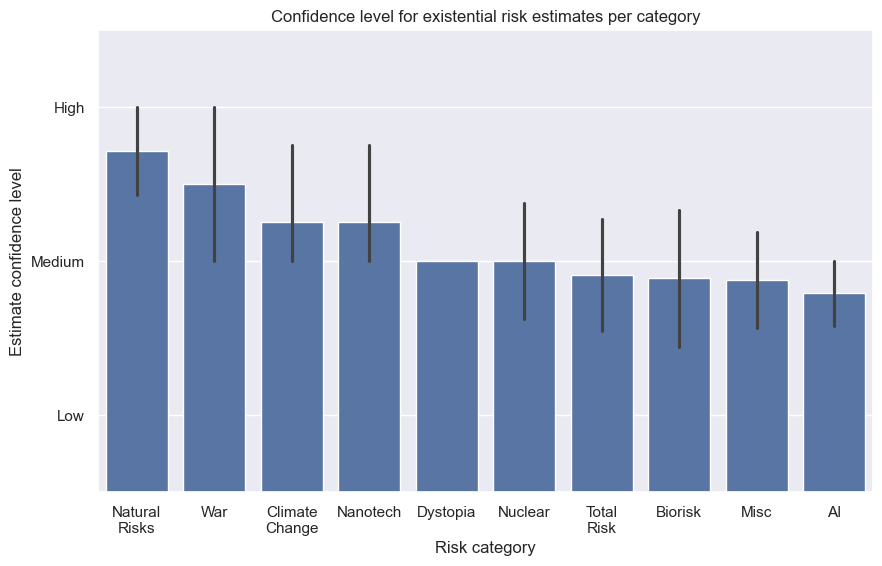

In [363]:
# Visualize the confidence level for each category.
# Plot the confidence level for each category sorted by confidence level.
categories_sorted_by_confidence = df.groupby('category_alias')['estimate_confidence_numeric'].mean().sort_values(ascending=False).index

# Set plot size to 10 by 6 inches
sns.set_theme(rc={'figure.figsize': (10, 6)})

# Create plot with seaborn
ax = sns.barplot(x='category_alias', y='estimate_confidence_numeric', data=df, order=categories_sorted_by_confidence)

# Set plot title, labels and ticks
ax.set_ylim(0.5, 3.5)
ax.set_yticks([1, 2, 3], ['Low', 'Medium', 'High'])
ax.set_title('Confidence level for existential risk estimates per category')
ax.set_ylabel('Estimate confidence level')
ax.set_xlabel('Risk category')

### Observations - TLDR 

- Natural risks have the highest estimate confidence, likely due to better scientific understanding and historical data
- AI and miscellaneous risks show the lowest confidence, possibly reflecting their emerging and complex nature
- War, climate change, and nanotech risks have moderately high confidence levels
- Nuclear risks show medium confidence, despite being a long-studied threat

### Observations - Detail

When we look at natural risks having the highest estimate confidence, this makes sense from multiple angles. We have historical data about supervolcanoes, asteroids, and other natural catastrophes. We understand their mechanisms well through scientific study. However, this high confidence might be somewhat misleading when considering existential risk specifically. It is important to remember that the actual existential risk due to natural disaster has a mean of 0.09%. While natural disasters could be devastating, these estimates suggest they might not pose as significant a threat to humanity's long-term potential as their high confidence rating suggests. Even a supervolcano eruption, while catastrophic, would likely leave some human populations surviving.

The lower confidence in AI risk estimates is particularly interesting. This lower confidence doesn't necessarily indicate a lower risk level - in fact, many experts consider AI one of the most serious existential threats (mean AI x-risk at 16% per century and mean of 1% as per this dataset). The low confidence instead reflects the complexity and unprecedented nature of artificial intelligence. AI poses unique challenges because it could affect humanity's trajectory in multiple ways: through direct extinction scenarios, by creating unaligned superintelligent systems, or by leading to dystopian outcomes that permanently diminish human potential. This multi-faceted nature of AI risk makes confident estimation inherently difficult.

War and nuclear risks show medium confidence levels, which reflects an interesting tension. On one hand, we have significant historical data about warfare and understand nuclear weapons' immediate effects well. However, the confidence isn't as high as natural risks because the cascading effects of modern warfare, especially considering technological advancement, are harder to predict. As mentioned in sources - like Toby Ord's The Precipice-and similar works, while nuclear war would be catastrophic, some experts argue it might not necessarily lead to human extinction - though it could severely impact our civilization's trajectory.

Climate change shows relatively high confidence, likely due to robust scientific modeling and understanding of physical mechanisms. However, this confidence might again need to be considered carefully in the context of existential risk specifically. While climate change poses severe challenges, its direct extinction potential might be lower than other risks-mean climate change x-risk estimate at 0.4%, median 0.3% per century-, though it could act as a risk factor that makes humanity more vulnerable to other threats.

The low confidence in miscellaneous risks makes sense as this category likely includes novel or poorly understood threats. However, this low confidence shouldn't be interpreted as low importance - unknown risks could be some of the most dangerous, precisely because we don't understand them well enough to prepare adequately.

What's particularly notable is how this confidence distribution somewhat inverts what many existential risk researchers consider to be the actual risk levels. The risks we're most confident in estimating (natural disasters) are often considered less likely to cause human extinction than risks we're less confident about estimating (like AI or unknown risks). This **suggests that our ability to confidently estimate a risk doesn't necessarily correlate with its actual potential to end human civilization** or prevent humanity from reaching its potential.

This analysis points to a crucial insight: we need to be careful not to conflate our confidence in estimating a risk with the severity or probability of that risk. Sometimes the hardest risks to estimate confidently might be the ones we need to worry about most.

The less confidence an expert has in their estimate, the vaguer the language they'll use to express their estimate. This results in higher uncertainty when trying to turn their estimates into a numeric value.

# 🤖 Time Period Conversion Confidence Assessment Methodology

The conversion confidence scores represent our level of certainty in converting risk estimates from their original timeframes to a standardized per-century metric. Like the estimate confidence, this uses a 3-point scale where:
- 1 = Low conversion confidence
- 2 = Medium conversion confidence
- 3 = High conversion confidence

## Primary Evaluation Criteria

### 1. Original Timeframe Clarity

- **High (3)**: Original timeframe explicitly stated with clear boundaries (e.g., "by 2100" or "in the next 100 years")
- **Medium (2)**: Timeframe implied or requires minor inference (e.g., "annual risk" requiring compound probability calculation)
- **Low (1)**: Timeframe ambiguous or requires significant assumptions (e.g., "in the long term" or "eventually")

### 2. Conversion Complexity

- **High (3)**: Direct century estimates or simple linear scaling needed
- **Medium (2)**: Requires compound probability calculations or moderate mathematical transformations
- **Low (1)**: Complex conversions with multiple assumptions or unclear mathematical relationship

### 3. Temporal Independence

- **High (3)**: Risk likely consistent over time or temporal dependence well-understood
- **Medium (2)**: Some temporal dependence but reasonably manageable
- **Low (1)**: Strong temporal dependence making conversion highly uncertain

### 4. Underlying Assumptions

- **High (3)**: Few necessary assumptions, all well-justified
- **Medium (2)**: Multiple assumptions required but reasonable
- **Low (1)**: Many assumptions or particularly strong assumptions needed

## Common Conversion Types and Their Typical Confidence Levels

### Direct Century Estimates

Example: "5% by 2100"

- No conversion needed
- Clear timeframe
- Typical confidence: High (3)

### Annual to Century Conversion

Example: "0.29% annual risk"

- Requires compound probability calculation: 1-(1-p)^100
- Assumes constant annual risk
- Typical confidence: Medium (2)

### Multi-Century to Century Conversion

Example: "5% before 5100 years"

- Requires significant assumptions about risk distribution
- Complex temporal scaling
- Typical confidence: Low (1)

### Near-Term to Century Conversion

Example: "2% by 2050"

- Requires scaling to full century
- Assumes linear risk scaling
- Typical confidence: Medium to High (2-3)

## Conversion Principles

### 1. Risk Distribution Assumptions

When converting estimates, we consider how risk might be distributed over time:
- Linear distribution: Risk increases steadily
- Front-loaded: Higher risk in earlier periods
- Back-loaded: Higher risk in later periods
- Uniform: Constant risk over time

### 2. Temporal Scaling Methods

Different approaches based on estimate type:
- Linear scaling: Multiplying by ratio of time periods
- Compound probability: Using probability theory for repeated independent events
- Conservative scaling: Using upper bounds when uncertainty is high

### 3. Special Cases

Some estimates require special handling:
- Conditional probabilities
- Cumulative risks
- Interconnected risks
- Threshold effects

## Limitations and Considerations

### Known Limitations

1. Assumption of time independence may not hold
2. Risk profiles might change dramatically over time
3. Complex interdependencies between different risks
4. Historical data might not predict future risks well

### Usage Guidelines

1. Consider conversion confidence alongside estimate confidence
2. Use more conservative estimates when conversion confidence is low
3. Acknowledge temporal uncertainties in analysis
4. Consider multiple conversion methods for sensitive analyses

## Examples with Reasoning

### High Conversion Confidence Example

Original: "1% by 2100"
- Already in century format
- No conversion needed
- Clear timeframe
- Result: High confidence (3)

### Medium Conversion Confidence Example

Original: "0.29% annual risk"
- Requires compound probability calculation
- Assumes constant annual risk
- Moderate mathematical transformation
- Result: Medium confidence (2)

### Low Conversion Confidence Example

Original: "5% over millions of years"

- Extremely long timeframe
- Many assumptions needed
- Complex temporal scaling
- Result: Low confidence (1)

## Recommendations for Use

1. **Primary Application**: Use conversion confidence to:
   - Weight different estimates in meta-analyses
   - Guide sensitivity testing
   - Inform uncertainty quantification
   - Prioritize data collection efforts

2. **Combined Analysis**: Consider both estimate and conversion confidence when:
   - Comparing different risk assessments
   - Making policy recommendations
   - Planning risk mitigation strategies
   - Communicating uncertainty to stakeholders

Text(0.5, 0, 'Risk category')

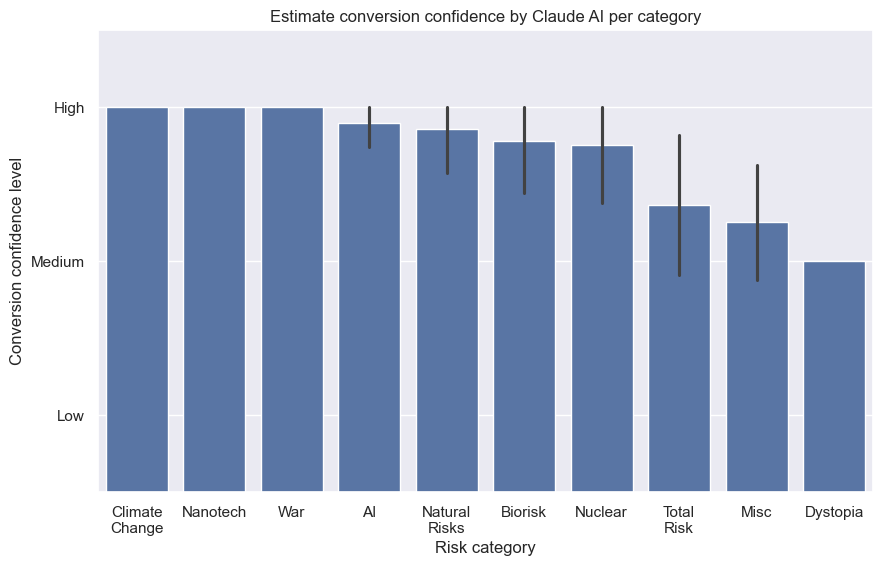

In [364]:
# Visualize the conversion confidence level for each category.

# Sort the categories by conversion confidence level
categories_sorted_by_conversion_confidence = df.groupby('category_alias')['conversion_confidence_numeric'].mean().sort_values(ascending=False).index

# Create plot with seaborn
ax = sns.barplot(x='category_alias', y='conversion_confidence_numeric', data=df, order=categories_sorted_by_conversion_confidence)

# Set plot title, labels and ticks
ax.set_ylim(0.5, 3.5)
ax.set_yticks([1, 2, 3], ['Low', 'Medium', 'High'])
ax.set_title('Estimate conversion confidence by Claude AI per category')
ax.set_ylabel('Conversion confidence level')
ax.set_xlabel('Risk category')

### Observations

The plot reveals several insights about conversion confidence across risk categories:

1. High consistency (no variance) in:
- Climate Change
- Nanotech 
- War
These categories show uniformly high conversion confidence, suggesting estimates typically use clear timeframes and straightforward conversions.

2. Moderate variance in:
- AI
- Natural Risks
- Biorisk
- Nuclear
These show some spread in conversion confidence, indicating a mix of estimate types - some with clear timeframes, others requiring more complex conversions.

3. High variance in:
- Total Risk
- Miscellaneous
These categories show the widest spread in conversion confidence, suggesting inconsistent estimation methods and timeframes.

4. Clear hierarchy:
- Climate Change, Nanotech, and War estimates are most reliably converted
- Miscellaneous and Dystopia estimates are least reliably converted

This pattern suggests that newer, more structured research fields tend to use more standardized timeframes, while broader or more speculative categories often use varied or less precise temporal frameworks.

The lower confidence in Total Risk conversion is particularly notable since it affects overall existential risk assessments. This suggests meta-analyses should carefully weight estimates based on conversion confidence.

**Question**: Could it be that the conversion confidence and the estimate confidence are correlated? 

**Hypothesis**: The less confidence an expert has in their estimate, the vaguer the language they'll use to express their estimate. This results in higher uncertainty when trying to turn their estimates into a numeric value.

However, I think this sort of analysis is out of the scope of this investigation. Since in the end, we're more interested in the overall risk estimates, rather on their metadata (like how estimate confidence and conversion confidence correlate). I'll just leave this hypothesis here as an interesting insight from looking at the data.

# Distribution Analysis

In this section we'll look at how the estimates are distributed per risk category.

In [365]:
# Split dataframe into two dataframes based on the number of estimates per category 
n_threshold = 2
n_estimates_per_category = df['category_alias'].value_counts()

categories_with_2_estimates_or_more = n_estimates_per_category[n_estimates_per_category > n_threshold].index
categories_with_2_estimates_or_less = n_estimates_per_category[n_estimates_per_category <= n_threshold].index

df_n_estimates_geq_threshold = df[df['category_alias'].isin(categories_with_2_estimates_or_more)]
df_n_estimates_leq_threshold = df[df['category_alias'].isin(categories_with_2_estimates_or_less)]

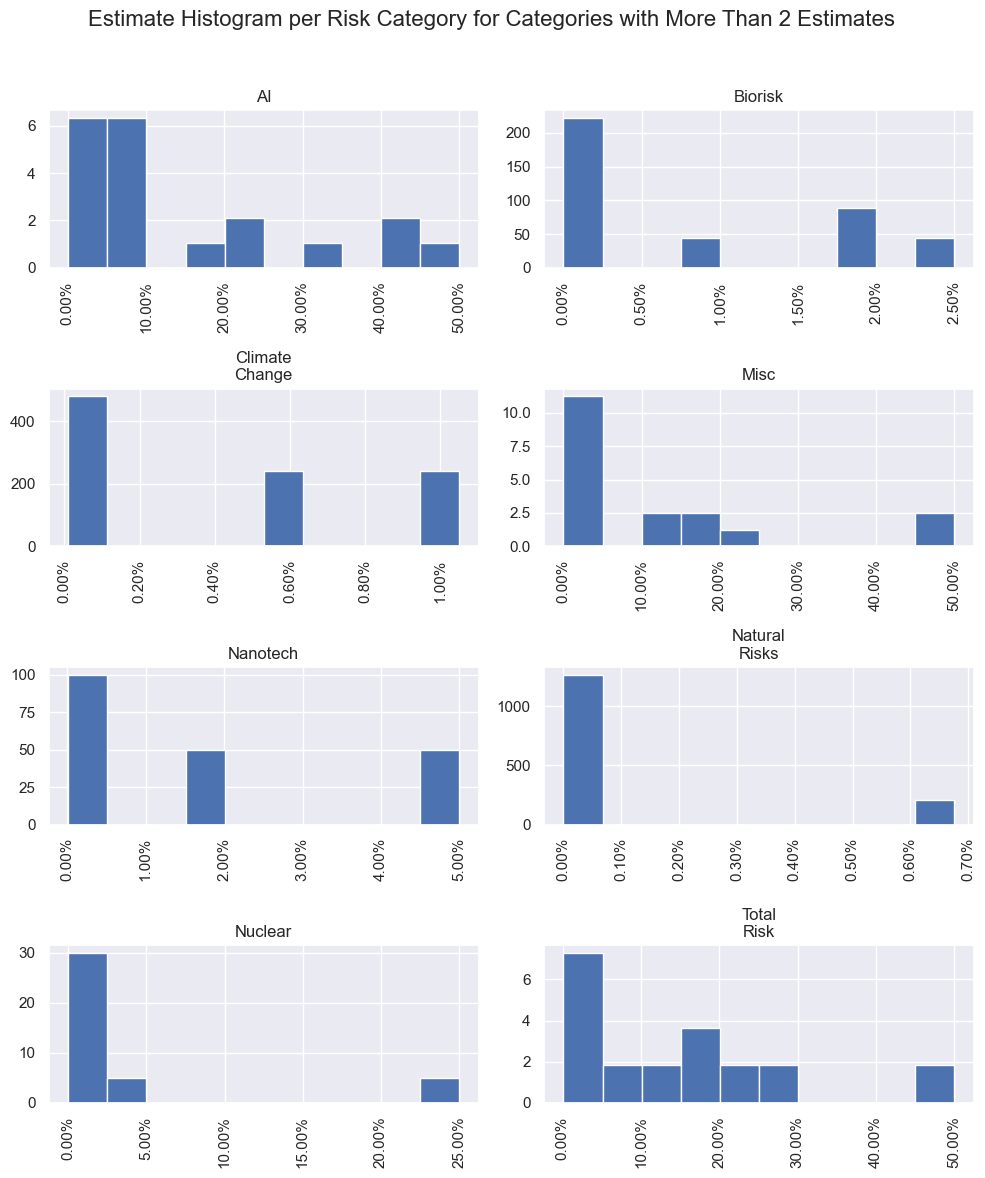

In [366]:
# Plot a estimate histogram per risk category for categories with more than n_threshold estimates
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 12))
axes_flat = axes.flatten()

df_n_estimates_geq_threshold['per_century_risk'].hist(by=df_n_estimates_geq_threshold['category_alias'], bins=10, sharex=False, sharey=False, density=True, ax=axes_flat[:8])

# Format the x labels as percentage
for ax in axes_flat[:8]:
  ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2%}'))

fig.suptitle(f'Estimate Histogram per Risk Category for Categories with More Than {n_threshold} Estimates', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])

## Initial observations

The histogram for the different categories reveals that some categories seem to be multimodal, like AI, and Biorisk-possibly also Total Risk, and Climate Change, though these might also just be considered skewed to the left.

However, most categories seem to be skewed towards lower values.

Furthermore, there are important differences in the scale of the estimates. While some estimates range between 0 and 50% like AI, others, like Biorisk range from 0 to 2.5%.

## Summary

1. Scale Differences:
- Risk estimates vary by orders of magnitude between categories
- Natural risks and biorisk have lower estimates (<1%)
- AI and total risk have much higher estimates (up to 50%)

2. Distribution Shapes:
- AI shows two main clusters: one around 5-10% and another around 35-40%
- Nuclear risks show a strong peak at very low percentages with a small secondary peak around 25%
- Miscellaneous risks show wider spread, suggesting higher uncertainty
- Natural risks are highly concentrated in the lowest bin

3. Statistical Properties:
- Most categories appear non-normal
- Heavy left skew suggests consensus on lower bounds but disagreement on upper bounds
- Wide gaps between clusters in some categories may indicate fundamental disagreements in assessment methodology or assumptions

These patterns suggest different weighting strategies may be needed per category, potentially:
- AI: Cluster analysis before aggregation
- Natural/Nuclear: Robust estimators for heavily skewed data
- Total Risk: Either transform to normalize or use non-parametric methods

### AI

We'll first analyze the AI risk estimates, which seem to follow the most complex pattern.

The AI estimates seem to be clustered in three clusters. But before performing a clustering analysis using k-means, let's see if the data follows a time-based pattern.


(-1.0, 9.0)

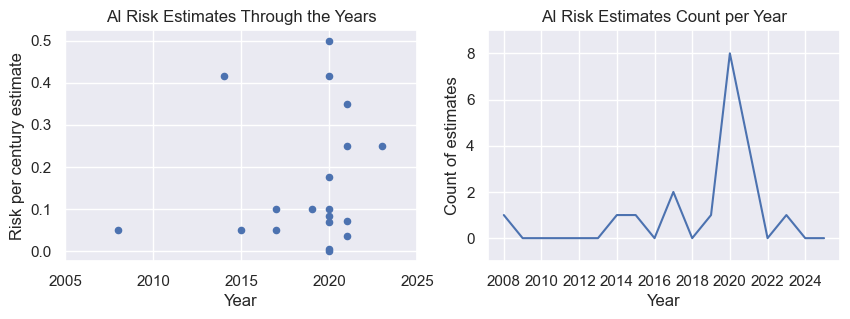

In [367]:
# Plot estimates through the years for the ai category
df_ai_risks = df[df['category_alias'] == 'AI'].copy()
fig, axes = plt.subplots(figsize=(10, 3), ncols=2)

# Plot the risk estimates per century throughout the years
ax = axes[0]
df_ai_risks.plot(kind='scatter', x='date', y='per_century_risk', ax=ax)
ax.set_title('AI Risk Estimates Through the Years')
ax.set_ylabel('Risk per century estimate')
ax.set_xlabel('Year')
ax.set_xticks(np.arange(2005, 2026, 5))

# Plot the count of risk estimates per year
ax=axes[1]
year_range = [2008, 2026]
value_count_per_year = np.zeros(year_range[1] - year_range[0])
for year in range(*year_range):
  value_count_per_year[year - year_range[0]] = df_ai_risks[df_ai_risks['date'] == year].shape[0]

ax.plot(np.arange(*year_range), value_count_per_year)
ax.set_title('AI Risk Estimates Count per Year')
ax.set_ylabel('Count of estimates')
ax.set_xlabel('Year')
ax.set_xticks(np.arange(year_range[0], year_range[1], 2))
ax.set_ylim(-1, 9)

Is there any correlation between the year when the estimate was made and the magnitude of the estimate? It seems that earlier estimates were lower, but we see a big increment in the number of estimates but also in the spread that started in 2019 and peaked in 2020.


Summary Statistics:
Mean estimate: 0.162
Median estimate: 0.100
Std dev: 0.155
Number of estimates: 19
Year range: 2008 - 2023

Correlation Analysis:
Pearson correlation coefficient: 0.135 (p-value: 0.582)
Spearman correlation coefficient: 0.162 (p-value: 0.508)


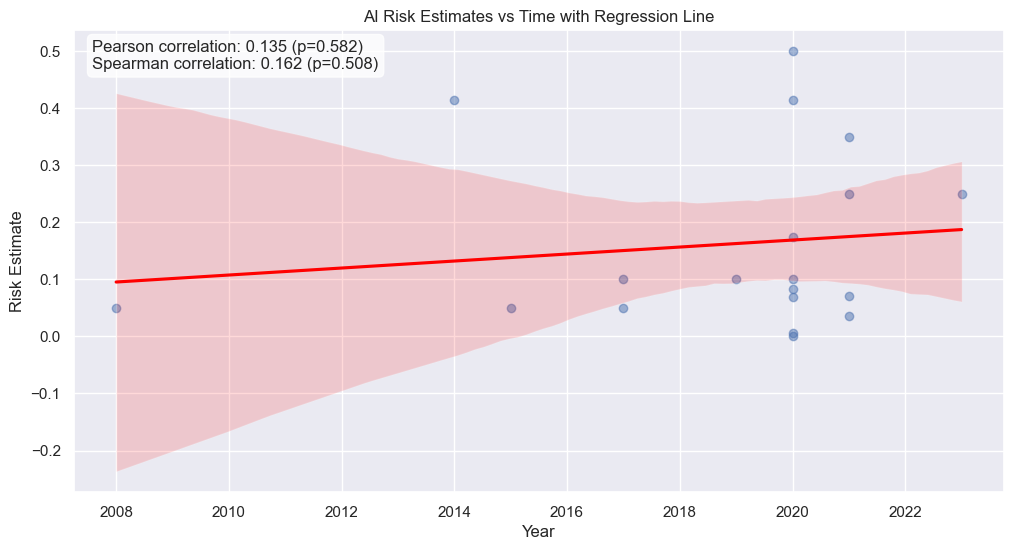

In [368]:
from scipy import stats

# Calculate correlation coefficients
pearson_corr, pearson_p = stats.pearsonr(df_ai_risks['date'], df_ai_risks['per_century_risk'])
spearman_corr, spearman_p = stats.spearmanr(df_ai_risks['date'], df_ai_risks['per_century_risk'])

# Create visualization
plt.figure(figsize=(12, 6))

# Scatter plot with regression line
sns.regplot(data=df_ai_risks, x='date', y='per_century_risk', scatter_kws={
            'alpha': 0.5}, line_kws={'color': 'red'})
plt.title('AI Risk Estimates vs Time with Regression Line')
plt.xlabel('Year')
plt.ylabel('Risk Estimate')

# Add correlation information
plt.text(0.02, 0.98,
         f'Pearson correlation: {pearson_corr:.3f} (p={pearson_p:.3f})\n' +
         f'Spearman correlation: {spearman_corr:.3f} (p={spearman_p:.3f})',
         transform=plt.gca().transAxes,
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Calculate summary statistics
summary_stats = {
    'Mean estimate': df_ai_risks['per_century_risk'].mean(),
    'Median estimate': df_ai_risks['per_century_risk'].median(),
    'Std dev': df_ai_risks['per_century_risk'].std(),
    'Number of estimates': len(df_ai_risks),
    'Year range': f"{df_ai_risks['date'].min()} - {df['date'].max()}"
}

print("\nSummary Statistics:")
for key, value in summary_stats.items():
    print(f"{key}: {value:.3f}" if isinstance(
        value, float) else f"{key}: {value}")

print("\nCorrelation Analysis:")
print(f"Pearson correlation coefficient: {pearson_corr:.3f} (p-value: {pearson_p:.3f})")
print(f"Spearman correlation coefficient: {spearman_corr:.3f} (p-value: {spearman_p:.3f})")

Based on this analysis we can draw the following conclusions:

1. The correlation between date and risk estimate magnitude is weak (Pearson: 0.135, p=0.582; Spearman: 0.162, p=0.508) but shows a slight upward trend.

2. Notable observations:
- Estimates become more dispersed in recent years (2020-2022)
- Wide confidence interval (pink shading) indicates high uncertainty
- Most estimates cluster between 0-0.25 (25% risk)
- A few outlier estimates around 0.4-0.5 (40-50% risk)

3. Key limitations:
- Sample size relatively small
- Estimates concentrated in recent years
- Different methodologies between experts
- Possible publication bias

Based on the correlation analysis between AI risk estimates and their dates, we can confidently set aside temporal correlation as a significant factor in our investigation. The weak Pearson correlation (0.135) and Spearman correlation (0.162), combined with high p-values (0.582 and 0.508 respectively), indicate that there is no statistically significant relationship between when an estimate was made and its magnitude. While we observe a slight upward trend in the regression line, the wide confidence interval and scattered distribution of the data points suggest this trend is more likely due to random variation than a meaningful pattern.

In [369]:

ax.set_title('AI Risk Estimates Count Through the Years')
ax.set_ylabel('Count of estimates')
ax.set_xlabel('Year')
ax.set_xticks(np.arange(2005, 2026, 5))

### Clustering

To come up with a weighted value that expresses a "summarized" estimate from all estimates, we'll perform k-means clustering, and then compute a weighted average based on the cluster sizes.

We can observe between two and three clusters for the AI estimates. We'll use three clusters.

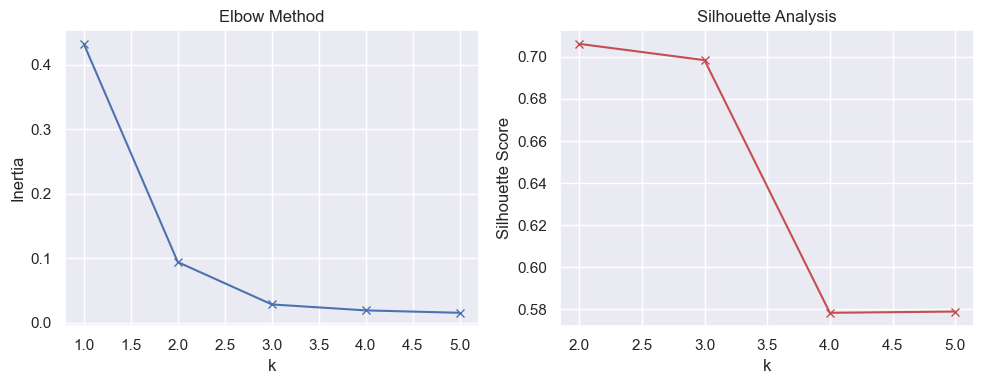

In [370]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


# Reshape data to 2D array
X = df_ai_risks['per_century_risk'].values.reshape(-1, 1)

# Calculate inertia (within-cluster sum of squares) for different k
inertias = []
silhouette_scores = []
k_range = range(1, 6)

for k in k_range:
   kmeans = KMeans(n_clusters=k, random_state=42)
   kmeans.fit(X)
   inertias.append(kmeans.inertia_)
   if k > 1:  # Silhouette score needs at least 2 clusters
       silhouette_scores.append(silhouette_score(X, kmeans.labels_))

# Plot elbow curve
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method')

# Plot silhouette scores
plt.subplot(1, 2, 2)
plt.plot(k_range[1:], silhouette_scores, 'rx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')

plt.tight_layout()
plt.show()

According to the elbow and silhouette score, the best results are obtained for three clusters, which is not particularly surprising. So we'll use three clusters and analyze the distributions for each.

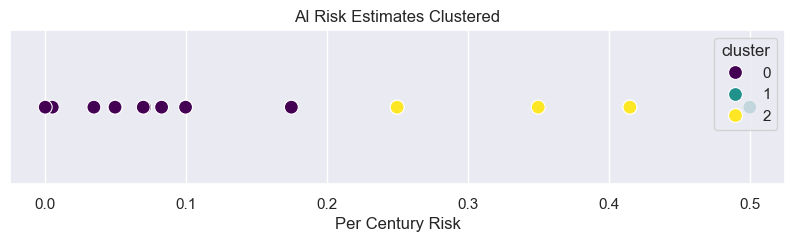

In [375]:
# Use kmeans with 3 clusters
kmeans_3 = KMeans(n_clusters=3)
kmeans_3.fit(X)

# Add clusters to the dataframe
df_ai_risks['cluster'] = kmeans_3.predict(X)

# Visualize clusters on a line (since the data is one dimensional)
plt.figure(figsize=(10, 2))
sns.scatterplot(data=df_ai_risks, x='per_century_risk', y=[0]*len(df_ai_risks), hue='cluster', palette='viridis', s=100)
plt.yticks([])
plt.xlabel('Per Century Risk')
plt.title('AI Risk Estimates Clustered')
plt.show()

### Cluster Characteristics:

- Low Risk Cluster (0.0005-0.1): Contains most estimates, averaging around 5% risk
- Medium Risk Cluster (0.2-0.3): Small cluster centered around 25% risk
- High Risk Cluster (0.4-0.5): Small cluster with the highest risk estimates around 45%

Based on these clusters, we can come up with weighted averages for each of the clusters, to reflect the trimodal nature of the AI risk estimates distribution.

## Weighting

Now, Claude assigned confidence levels for the estimates and for the conversion themselves. We'll now explore using these data.

The goal will be to find an appropriate weighing mechanism to account for the uncertainty in the estimates and in their conversion.

It seems that the confidence level varies from category to category. Some categories do not have variation, like Dystopia, which only has one estimate.

Let's use this information to create weighted averages using both the estimate confidence and the conversion confidence.

I'll use a weighted geometric mean model, that is based on a weight $\alpha$ that describes the "relevance" of one particular weight. Since we have two weight sources (estimate confidence and conversion confidence), we can create an aggregated weight based on the weighted geometric mean that we can use compute weighted averages.

The weighted geometric mean can be computed with:

$$
\begin{align}
w&=w_1^\alpha \cdot w_2^{1-\alpha}
\end{align}
$$

In [ ]:
def weighted_geometric_mean(w1, w2, alpha):
    return (w1**alpha * w2**(1-alpha))

# We'll give more weight to the estimate confidence level
alpha = 0.6

# Calculate the weighted geometric mean
weighted_mean = weighted_geometric_mean(df['estimate_confidence_numeric'], df['conversion_confidence_numeric'], alpha)

# Normalize the weighted mean to be between 0 and 1
max_weighted_mean = weighted_mean.max()
weighted_means_normalized = weighted_mean / max_weighted_mean

# Add the weighted mean to the dataframe
df['weighted_confidence_mean'] = weighted_means_normalized
df['weighted_confidence_mean'].describe()

/var/folders/gp/134vcy4x6c19634zvbkbff900000gn/T/ipykernel_18164/954904296.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['weighted_confidence_mean'] = weighted_means_normalized


count    85.000000
mean      0.741996
std       0.184749
min       0.333333
25%       0.666667
50%       0.784053
75%       0.784053
max       1.000000
Name: weighted_confidence_mean, dtype: float64

Text(0.5, 0, 'Risk category')

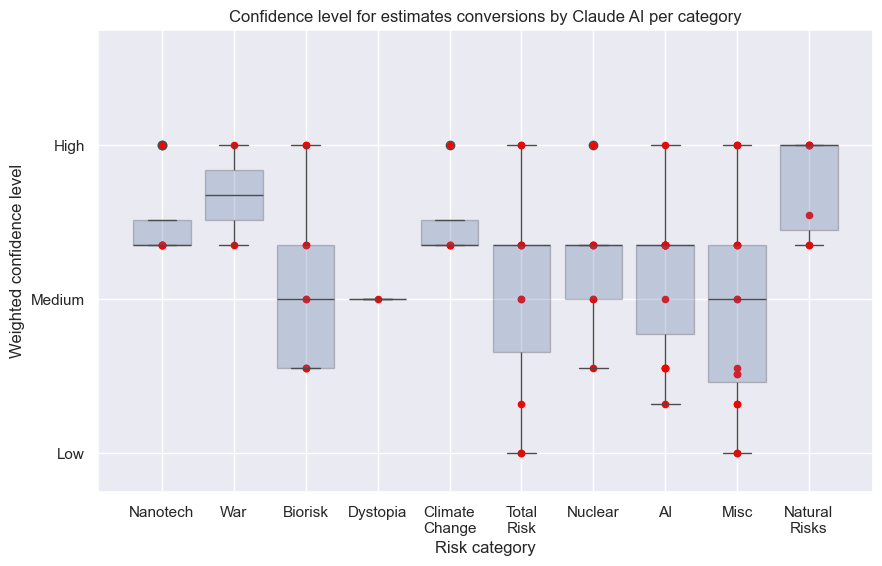

In [ ]:
# Visualize the weighted confidence for each category.
# Start plot from 1 since it's the lowest confidence level
ax = sns.boxplot(x='category_alias', y='weighted_confidence_mean', data=df, boxprops=dict(alpha=0.3))
df.plot(kind='scatter', x='category_alias', y='weighted_confidence_mean', color='red', figsize=(10, 6), ax=ax)
ax.set_ylim(.25, 1.25)
# Set y tick labels to Low, Medium and High using the mapping above
ax.set_yticks([1/3, 2/3, 1], ['Low', 'Medium', 'High'])
ax.set_title('Confidence level for estimates conversions by Claude AI per category')
ax.set_ylabel('Weighted confidence level')
ax.set_xlabel('Risk category')

Now apply the weights to obtain a weighted average per category.

In [ ]:
df_by_category = df.groupby('risk_category').apply(lambda x: np.average(x['per_century_risk'], weights=x['weighted_confidence_mean']))

# Visualize the calculated mean with the actual values.


/var/folders/gp/134vcy4x6c19634zvbkbff900000gn/T/ipykernel_18164/1739411070.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_by_category = df.groupby('risk_category').apply(lambda x: np.average(x['per_century_risk'], weights=x['weighted_confidence_mean']))


Text(0.5, 0, 'Risk category')

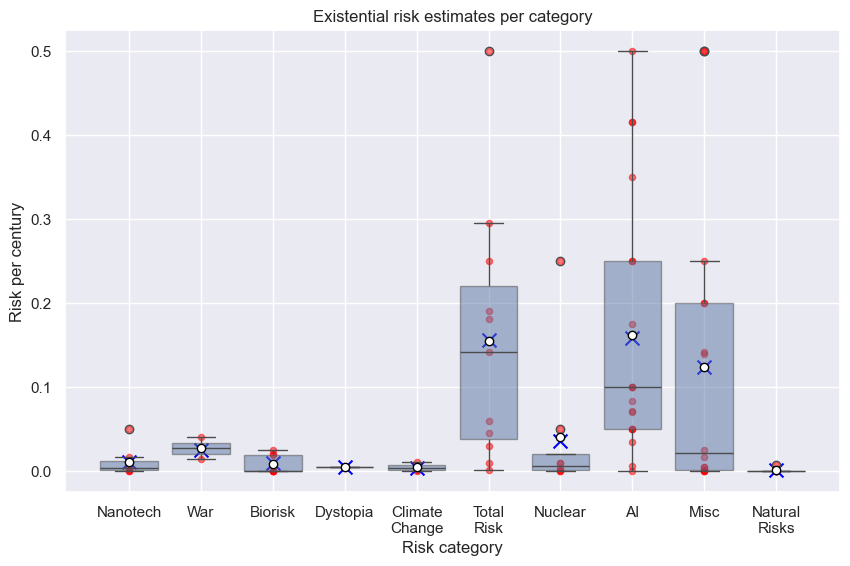

In [ ]:
# Plot the risk categories in a box plot.
ax = sns.boxplot(x='category_alias', y='per_century_risk', data=df, showmeans=True, meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black"}, boxprops=dict(alpha=0.5))

# Plot the actual values on top.
df.plot(kind='scatter', x='category_alias', y='per_century_risk', color='red', alpha=0.5, figsize=(10, 6), ax=ax)

# Plot the weighted mean on.
categories = [categories_aliases[cat] for cat in df_by_category.index]
ax.scatter(x=categories, y=df_by_category, color='blue', marker='x', s=100)

# Set the title and labels
ax.set_title('Existential risk estimates per category')
ax.set_ylabel('Risk per century')
ax.set_xlabel('Risk category')

## Conclusions

# Patterns in Existential Risk Estimates: A Deep Dive

When examining our dataset of existential risk estimates, several patterns emerge that tell us about how experts view different potential threats to humanity. Let's explore what the data reveals about these risk assessments and the confidence levels associated with them.

## Risk Level Distribution

Perhaps the most salient pattern in our data is how the risk estimates vary across different categories. **War** emerges as the category with both the highest median risk and the largest spread in estimates. This wide range of estimates, from near zero to about 90%, suggests significant disagreement among experts about the likelihood of war leading to existential catastrophe.

Artificial Intelligence follows as our second-highest risk category. Like war, AI risk estimates show considerable spread, though not quite as dramatic. This variation might reflect the inherent uncertainty in predicting the outcomes of a technology that's still rapidly evolving.

In contrast, Natural Risks and Dystopia show remarkably low risk estimates with minimal spread. This consistency among experts is particularly interesting – it suggests a strong consensus that natural disasters pose a relatively small existential threat compared to human-made risks.

## The Confidence Puzzle

One of the most intriguing patterns emerges when we look at how confident experts are in their estimates. Curiously, we find an inverse relationship between risk levels and confidence: categories with higher risk estimates tend to have lower confidence levels, and vice versa.

Natural Risks and Climate Change show the highest confidence levels. This makes intuitive sense for natural risks – we have historical data and scientific models to help us understand things like asteroid impacts or supervolcanoes. Climate Change estimates, while serious, benefit from decades of scientific research and modeling.

The lower confidence levels in AI and War risk estimates tell another story. These categories involve complex human systems, unpredictable technological advancement, and intricate social and political factors. The uncertainty here reflects the inherent difficulty in predicting human behavior and technological development.

## The Impact of Weighting

When we applied confidence-based weights to our analysis, we discovered something remarkable: weighted means tend to be lower than unweighted means. This suggests that experts who are more confident in their estimates generally predict lower risks than their less confident colleagues.

This effect is particularly pronounced in the War category, where the weighted mean falls significantly below the median. This might indicate that experts who have studied war-related risks most deeply are actually more optimistic about our chances of avoiding catastrophe.

## The Outlier Story

Almost every category in our dataset shows outliers, but they tell an asymmetric story. We see outliers predominantly on the high end of risk estimates, with very few on the low end. This creates a right-skewed distribution that suggests while most experts cluster around more moderate estimates, there's a consistent minority who see significantly higher risks.

The most extreme outliers appear in the War and Total Risk categories, representing some experts' views that these threats pose nearly certain existential risk. These outlying views, while minority positions, raise important questions about worst-case scenarios that perhaps deserve special attention.

## Final Thoughts

These patterns reveal a complex landscape of existential risk assessment. While we see strong consensus in some areas (like natural risks), other domains show significant uncertainty and disagreement. The inverse relationship between risk levels and confidence suggests that the threats we worry about most are also the ones we understand least well.

This analysis helps us understand not just the risks themselves, but also how experts think about and quantify these risks. It highlights areas where we might need more research and areas where expert consensus might guide policy and preparation efforts.

Would you like to explore any of these patterns in more detail? We could dive deeper into specific correlations, examine distribution shapes within categories, or investigate how different types of experts view these risks.

We see that the weighted means are mostly close to the actual mean, but are a little bit lower for categories where the values are more spread out.